# Lab 5

## Den huvudsakliga frågeställningen vi ville besvara var:  

"Vilka faktorer är mest bidragande till att anställda väljer att lämna företaget, och hur kan vi, baserat på dessa insikter, förutsäga vilka anställda som är mest benägna att lämna?"  

För att svara på detta har vi utvecklat och testat tre olika maskininlärningsmodeller:  
- Logistic Regression 
- Random Forest och  
- Gradient Boosting Machine (GBM).  

Vi har även hanterat den obalanserade datan genom att använda SMOTE (Synthetic Minority Over-sampling Technique) och justerat klassvikterna i modellerna. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import hvplot.pandas
from scipy.stats import chi2_contingency


In [2]:
df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

df.shape

(1470, 35)

In [30]:
import pandas as pd

# Steg 1: Datarensning
# Vi börjar med att kontrollera om det finns några saknade värden i vårt dataset och beräknar grundläggande deskriptiv statistik.
missing_values = df.isnull().sum()
descriptive_stats = df.describe()

print("Missing values:\n", missing_values)
print("\nDescriptive statistics:\n", descriptive_stats)

# Steg 2: Kodomvandling
# Vi omvandlar "Attrition"-kolumnen från "Yes"/"No" till 1/0 för att göra den mer lämplig för maskininlärningsmodeller.
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Steg 3: Hantering av kategorisk data
# Vi identifierar kolumner med få unika värden och omvandlar dem till dummyvariabler.
# Detta gör att vi kan använda dessa kategoriska data i våra maskininlärningsmodeller.
dummy_col = [column for column in df.drop('Attrition', axis=1).columns if df[column].nunique() < 20]
data = pd.get_dummies(df, columns=dummy_col, drop_first=True, dtype='uint8')

# Steg 4: Ta bort dubletter
# Vi tar bort dubletter från vårt dataset för att undvika överanpassning i våra modeller.
data = data.T.drop_duplicates().T
data.drop_duplicates(inplace=True)

print("\nShape of data after removing duplicates:", data.shape)

# Steg 5: Kontrollera för saknade värden igen
# Efter att vi har skapat dummyvariabler, kontrollerar vi igen för saknade värden för att säkerställa att vår data är ren.
missing_values_after = data.isnull().sum()
print("\nMissing values after creating dummies:\n", missing_values_after)

Missing values:
 Age                                 0
Attrition                        1470
BusinessTravel                      0
DailyRate                           0
Department                          0
DistanceFromHome                    0
Education                           0
EducationField                      0
EmployeeCount                       0
EmployeeNumber                      0
EnvironmentSatisfaction             0
Gender                              0
HourlyRate                          0
JobInvolvement                      0
JobLevel                            0
JobRole                             0
JobSatisfaction                     0
MaritalStatus                       0
MonthlyIncome                       0
MonthlyRate                         0
NumCompaniesWorked                  0
Over18                              0
OverTime                            0
PercentSalaryHike                   0
PerformanceRating                   0
RelationshipSatisfaction         

## Lär känna din data

För att få en djupare förståelse av datasetet utförde vi flera analyser och visualiseringar: 
- Beräkning av statistik
- Korrelation
- Visualiseringar
- Box Plots
- Histogram
- Spridningsdiagram

## Obalanserad dataset

## Beräkning av statistik:

Vi beräknade medel, median och percentiler för att förstå den centrala tendensen och spridningen i data.

### Korrelation:

Vi beräknade korrelationer mellan variabler för att identifiera starka relationer som kan vara användbara för att välja relevanta funktioner. 

## Visualiseringar

### Box plots: 

För att identifiera outliers. 

### Histogram:

För att visa spridningen av variabler. 

### Spridningsdiagram:

För att beskriva bivariata relationer mellan variabler. 

In [3]:
df.head

<bound method NDFrame.head of       Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationFi

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Tabellen beskriver unika värden som finns inom datasetet.

In [6]:
for column in df.columns:
    print(f"{column}: Unika värden {df[column].nunique()}")
    print("----------------------------------------------")

Age: Unika värden 43
----------------------------------------------
Attrition: Unika värden 2
----------------------------------------------
BusinessTravel: Unika värden 3
----------------------------------------------
DailyRate: Unika värden 886
----------------------------------------------
Department: Unika värden 3
----------------------------------------------
DistanceFromHome: Unika värden 29
----------------------------------------------
Education: Unika värden 5
----------------------------------------------
EducationField: Unika värden 6
----------------------------------------------
EmployeeCount: Unika värden 1
----------------------------------------------
EmployeeNumber: Unika värden 1470
----------------------------------------------
EnvironmentSatisfaction: Unika värden 4
----------------------------------------------
Gender: Unika värden 2
----------------------------------------------
HourlyRate: Unika värden 71
----------------------------------------------
JobInvolve

Tabellen beskriver max och minimi värden på olika kolumner som finns inom datasetet

In [7]:
cont_col = []
for column in df.columns:
    if df[column].dtypes != object and df[column].nunique() > 30:
        print(f"{column} : Minimum: {df[column].min()}, Maximum: {df[column].max()}")
        cont_col.append(column)
        print("====================================")

Age : Minimum: 18, Maximum: 60
DailyRate : Minimum: 102, Maximum: 1499
EmployeeNumber : Minimum: 1, Maximum: 2068
HourlyRate : Minimum: 30, Maximum: 100
MonthlyIncome : Minimum: 1009, Maximum: 19999
MonthlyRate : Minimum: 2094, Maximum: 26999
TotalWorkingYears : Minimum: 0, Maximum: 40
YearsAtCompany : Minimum: 0, Maximum: 40


### Sammanfattning:

* Det finns 2068 anställda på företaget.
* Den som har jobbat längst har gjort det i 40 år
* Den som tjänar minst har en lön på 2094, och den som tjänar mest har en lön på 26999
* Den som är yngst är 18 och äldst är 60
* Timlönen ligger mellan 30 och 100.


## Visualisering av data

In [8]:
df.hvplot.hist(y='Education', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [Education]   (Education_count)

In [9]:
df.hvplot.hist(y='EnvironmentSatisfaction', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [EnvironmentSatisfaction]   (EnvironmentSatisfaction_count)

In [10]:
df.hvplot.hist(y='JobSatisfaction', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [JobSatisfaction]   (JobSatisfaction_count)

In [11]:
df.hvplot.hist(y='JobLevel', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [JobLevel]   (JobLevel_count)

In [12]:
df.hvplot.hist(y='DistanceFromHome', by='Attrition', subplots=False, width=600, height=300, bins=30)

:NdOverlay   [Attrition]
   :Histogram   [DistanceFromHome]   (DistanceFromHome_count)

In [13]:
df.hvplot.hist(y='TrainingTimesLastYear', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [TrainingTimesLastYear]   (TrainingTimesLastYear_count)

In [14]:
df.hvplot.hist(y='PercentSalaryHike', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [PercentSalaryHike]   (PercentSalaryHike_count)

In [15]:
df.hvplot.hist(y='Age', by='Attrition', subplots=False, width=600, height=300, bins=35)

:NdOverlay   [Attrition]
   :Histogram   [Age]   (Age_count)

In [16]:
df.hvplot.hist(y='MonthlyIncome', by='Attrition', subplots=False, width=600, height=300, bins=50)

:NdOverlay   [Attrition]
   :Histogram   [MonthlyIncome]   (MonthlyIncome_count)

In [17]:
df.hvplot.hist(y='YearsAtCompany', by='Attrition', subplots=False, width=600, height=300, bins=35)

:NdOverlay   [Attrition]
   :Histogram   [YearsAtCompany]   (YearsAtCompany_count)

In [18]:
df.hvplot.hist(y='TotalWorkingYears', by='Attrition', subplots=False, width=600, height=300, bins=35)

:NdOverlay   [Attrition]
   :Histogram   [TotalWorkingYears]   (TotalWorkingYears_count)

***
Sammanfattning av visualisering:

- Fler män slutar jobba än kvinnor.
- De som har en låg `JobLevel`, `MonthlyIncome`, `YearAtCompany` och `TotalWorkingYears` tenderar att sluta.
- De anställda som reser ofta på jobbet tenderar att sluta i större utsträckning än andra anställda.
- De anställda som är gifta eller skilda har en större tendens att stanna kvar jämfört med de som är singel som har en större sannolikhet att sluta jobbet.
- De anställda som jobbar övertid har en större tendens att sluta jobba.


***

## Analys

Datasetet innehåller kolumnerna som ger information om företagets anställda: 
- deras ålder, 
- om de har lämnat företaget ("Attrition"), 
- deras resvanor i arbetet, daglig ersättning, 
- avdelning, 
- utbildning, 
- och många andra faktorer som kan tänkas påverka deras beslut att stanna eller lämna företaget.

Dataset innehåller 35 kolumner totalt, som täcker många olika. 
Från demografisk information till arbetsrelaterade detaljer.

## Steg för att analysera och identifiera indikationer för att stanna kvar på företaget.

1. Frågeställning & Problemformulering
2. Utforska & Förbered data
3. Deskriptiv statistik och visualisering
4. Prediktiv analys

### Frågeställning & Problemformulering

Vi behöver identifiera de faktorer som påverkar/mest bidrar till "Attration" det vill säga, varför anställda väljer att lämna företaget. Detta kan identifiera och förutse vilka anställda som löper störst risk att lämna, vilket skapar möjligheter för proaktiva åtgärder för att förbättra arbetarnas trivsel/insitament att stanna kvar.

#### Huvudfråga: 

**Vilka faktorer är mest bidragande till att anställda väljer att lämna företaget, och hur kan vi, baserat på dessa insikter, förutsäga vilka anställda som är mest benägna att lämna?** 

#### Underliggande frågeställningar:

De underliggande frågeställningarna kopplas till områden såsom, 
- **Demografisk och arbetsrelaterad bakgrund**, 
- **Arbetsmiljö och relationer**, 
- **Ekonomiska incitament och karriärsutveckling**, 
- **Prediktiv modellering**.

##### Demografisk och arbetsrelaterad bakgrund:

Hur påverkar demografiska faktorer (t.ex. ålder, kön, utbildningsnivå) sannolikheten för att en anställd lämnar företaget?
Påverkar arbetsrelaterade faktorer (t.ex. avdelning, jobbnivå, arbetsbelastning, överstid) en anställds beslut att lämna?

##### Arbetsmiljö och relationer:

Hur påverkar faktorer relaterade till arbetsmiljön och anställdas relationer (t.ex. jobbtillfredsställelse, relationer med chefer och kollegor, arbetslivsbalans) en anställds sannolikhet att lämna företaget?

##### Ekonomiska incitament och karriärutveckling:

Vilken roll spelar ekonomiska faktorer (t.ex. månadsinkomst, löneökningar, aktieoptioner) och karriärmöjligheter (t.ex. antal år i nuvarande roll, främjanden) i en anställds beslut att stanna eller lämna?

##### Prediktiv modellering:

Baserat på identifierade signifikanta faktorer, vilken prediktiv modell kan mest effektivt förutsäga "Attrition" bland anställda?

#### Hur dessa frågeställningar leder analysen

Genom att använda dessa frågeställningar, leder vi analaysen mot att identifiera de mest betydande faktorerna som påverkar "Attrition" och till att utbveckla en modell som kan förutsäga sannolikheten att anställda lämnar företaget. Processen leder förhoppningsivs till att effektivt använda tillgänglig data för att generera insikter som möjliggör proaktiva åtgärder.



## Val av analysmetod

För att förstå vilket prob lem som kan lösas med data vi har blir det viktigt att välja lämplig analysmetod och modeller som kan appliceras på datasetet för att svara på dessa frågor. Vi ser ett behov av en kombination av korrelationsanalys, deskriptiv analys och prediktiv modellering med tekniker som logistisk regression, beslutsträd, eller enemble-metoder som random forest eller gradient boosting machines.


### Korrelationsanalys

Inom denna uppgift kan korrelationsanalysen genomföras som ett inledande steg för att utforska data och identifiera potentiella förklarande variabler för "Attrition". Det inkluderar undersökandet av korrelation mellan "Attrition" och andra variabler. (Månadsinkomst, Nöjdhet, År på företaget) Stark korrelationer kan visa på viktiga faktorer som påverkar anställdas beslut att lämna.

**Syfte:**
Att fastställa styrkan och riktningen av sambandet mellan två kvantitativa variabler.

**Metoder:**
- Pearsons korrelationskoefficient (r): Mäter styrkan och riktningen av det linjära sambandet mellan två kontinuerliga variabler. Värdet på r varierar mellan -1 och 1, där 1 indikerar en perfekt positiv linjär relation, -1 en perfekt negativ linjär relation, och 0 inget linjärt samband.
- Spearmans rangkorrelationskoefficient: Används för att mäta styrkan och riktningen av sambandet mellan två variabler när åtminstone en av dem inte är normalfördelad eller när relationen inte är linjär. Liksom Pearsons, varierar Spearmans koefficient mellan -1 och 1.

**Varför**
- Identifierar Relationer: Korrelationsanalys kan hjälpa till att upptäcka och kvantifiera sambandet mellan "Attrition" och potentiella prediktorer som ålder, månadsinkomst, jobbtillfredsställelse, etc.
- Informationsunderlag för Modellering: Genom att identifiera variabler som har stark korrelation med "Attrition", kan ni göra mer informerade val om vilka variabler som ska inkluderas i den prediktiva modellen, vilket ökar modellens effektivitet och noggrannhet.
- Undviker Multikollinearitet: Genom att identifiera variabler som är starkt korrelerade med varandra, kan ni undvika att inkludera variabler som bär liknande information till modellen, vilket förhindrar problem med multikollinearitet i prediktiva modeller.

### Deskriptiv analys

**Syfte:**
Att utforska och förstå datans grundläggande egenskaper, inklusive fördelning av nyckelvariabler, genomsnittliga värden, och att identifiera mönster eller anomalier.

**Metoder:**
- Beräkning av deskriptiv statistik
- korrelationsanalys för att identifiera samband mellan variabler, 
och visuella representationer som 
- histogram, 
- box plots, 
- och spridningsdiagram.

**Varför:** 
Deskriptiv analys ger en solid grund för att förstå datakällan och kan hjälpa till att identifiera vilka variabler som är värda att undersöka närmare i den prediktiva modelleringen.

### Prediktiv modellering

**Syfte:**
Att utveckla en statistisk modell som kan förutsäga en anställds sannolikhet att lämna företaget baserat på olika faktorer.

**Metoder:**
- Logistisk Regression: Ger möjligheten att modellera sannolikheten för en binär händelse (t.ex., om en anställd lämnar eller stannar) baserat på en eller flera oberoende variabler. Den är lämplig för detta problem eftersom den också ger insikter om hur varje faktor påverkar sannolikheten för att lämna, vilket är värdefullt för att identifiera interventionspunkter.
- Beslutsträd och Random Forest: Dessa metoder är användbara för att hantera komplexa interaktioner mellan variabler och för att hantera både numeriska och kategoriska data utan att behöva omfattande förbehandling. Random forest, som är en ensemblemetod av beslutsträd, är särskilt bra på att hantera överanpassning och ger robusta prediktioner.
- Gradient Boosting Machines (GBM): GBM är en kraftfull ensembleteknik som bygger på att successivt förbättra modellens prediktioner genom att fokusera på tidigare fel. Den är effektiv för att identifiera komplexa mönster och interaktioner i datan och har ofta hög prediktiv prestanda.

**Varför**
Dessa metoder tillåter inte bara att förutsäga "Attrition" men ger också insikter om vilka faktorer som är mest inflytelserika, vilket direkt adresserar era frågeställningar. Dessutom erbjuder de flexibilitet för att hantera olika datatyper och komplexa relationer mellan variabler.


### Omkodning

Omkodning av "Attrition" är användbar för flera anledningar:

**Kompatibilitet**: De flesta maskininlärningsmodeller kräver numeriska inputvariabler. Att omvandla kategoriska variabler till ett numeriskt format gör att du kan använda dem som features i din modell.

**Effektivitet**: Binära variabler (som de kodade med 1 och 0) kan behandlas mer effektivt av algoritmer, både ur beräknings- och minnessynpunkt.

**Tolkning**: När "Attrition" är kodad som 0 och 1, representerar modellens output direkt sannolikheten för att en anställd kommer att lämna ("Yes" = 1). Detta gör det enklare att tolka modellens förutsägelser.




## Tvätta datan mer

### Dataförberedelse 

#### Omkodning av Kategoriska Variabler: 

Vi använde pd.get_dummies för att omvandla kategoriska variabler till dummy-variabler. Detta steg är viktigt för att möjliggöra för maskininlärningsmodellerna att hantera kategoriska data. 

#### SMOTE:

För att hantera obalansen i datasetet använde vi SMOTE, vilket syntetiskt ökar antalet minoritetsklassobservationer. Detta hjälper modellerna att lära sig bättre från en balanserad data, vilket är kritiskt när vi har få exempel på anställda som lämnar företaget. SMOTE skapar syntetiska exempel i minoritetsklassen genom att interpolera mellan befintliga data. 

#### Standardisering: 

Vi standardiserade de numeriska variablerna för att säkerställa att alla funktioner är på samma skala. Detta är särskilt viktigt för modeller som Logistic Regression som är känsliga för skalningen av inputdata. 

In [19]:
# Börja städa DATA
#
# Kolla efter saknade värden & räkna ut grundläggande Deskriptiv statistik
missing_values = df.isnull().sum()
descriptive_stats = df.describe()

# Koda om "Attrition" från "Yes"/"No" till 1/0.
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})


In [20]:
(missing_values)

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [21]:
(descriptive_stats)

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


## Analysresultat


### Missing values

Analysen indikerar att det inte finns några saknade värden i datasetet.
Detta är bra då det förenklar dataförberedelseprocessen.

### Deskriptiv statistik

Här får vi en överblick över datasetet, inklusive medelvärden, standardavvikelser, minimi- och maximivärden för varje numerisk kolumn.

**Ålder:** Anställdas ålder varierar från 18 till 60 år, med ett medelvärde på cirka 37 år.

**DailyRate:** Dagliga ersättningen varierar betydligt, från 102 till 1499, med ett medel på cirka 802.

**DistanceFromHome:** Avståndet hemifrån till jobbet varierar från 1 till 29 miles, vilket visar en bred spridning bland de anställda.

**YearsAtCompany:** Anställda har varit på företaget från 0 till 40 år, med ett medelvärde på cirka 7 år.

c:\Users\Cag\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


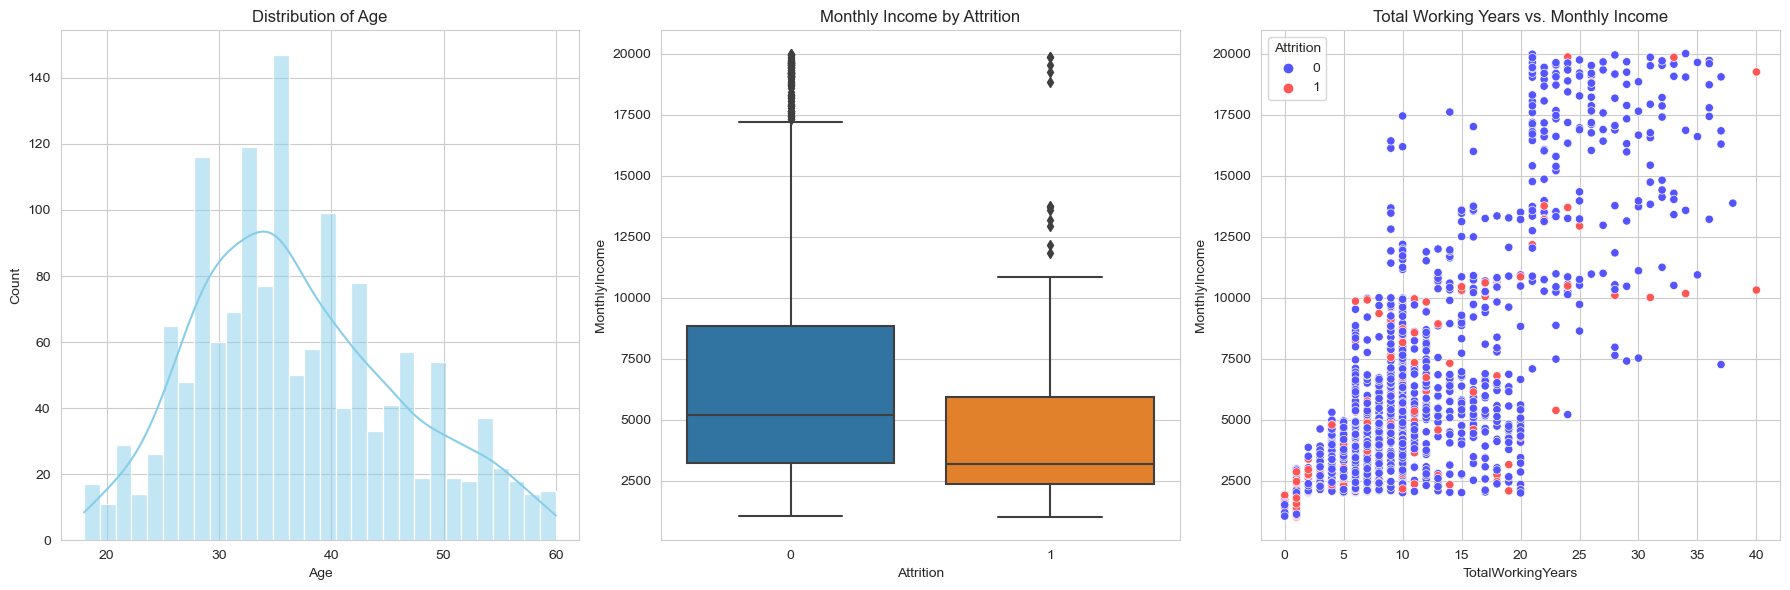

In [22]:
# Sätt utseende för plots
sns.set_style("whitegrid")

# Skapa subplot fig.
plt.figure(figsize=(18, 6))

# Histogram, åldersfördelning
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

# Boxplot månadslön för att identifiera outliers
plt.subplot(1, 3, 2)
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Monthly Income by Attrition')

# Scatter plot för TotalWorkingYears kontra MonthlyIncome
plt.subplot(1, 3, 3)
sns.scatterplot(x='TotalWorkingYears', y='MonthlyIncome', hue='Attrition', data=df, palette='seismic')
plt.title('Total Working Years vs. Monthly Income')

# Visa plot
plt.tight_layout()
plt.show()

## Visualiseringsanalys

För att öka förståelse för datasetets olika variabler samt identifiera möjliga kopplingar/samband mellan dem och "Attrition" analyserar vi data visuellt. 

### Vi skapar:
**Histogram** för att visa fördelningen av de anställdas ålder.

**Boxplot** för att visa fördelningen av "MonthlyIncome" och identifiera outliers.

**Spridningsdiagram** för att utforska relationen mellan "TotalWorkingYears" och "MonthlyIncome".

### Insikter
**Distribution of Age:** Histogrammet visar att åldersfördelningen bland de anställda är ganska jämn, med en liten topp runt 35 år. Det finns en bred spridning av åldrar vilket indikerar en diversifierad arbetsstyrka.

**Monthly Income by Attrition:** Boxplotten visar att de som lämnat företaget ("Yes") tenderar att ha en lägre månadsinkomster jämfört med de som stannar ("No"). Det finns också några outliers bland de som stannar, vilket tyder på att vissa anställda har avsevärt högre inkomster än genomsnittet.

**Total Working Years vs. Monthly Income:** Spridningsdiagrammet visar ett positivt samband mellan totalt antal arbetsår och månadsinkomst, vilket är förväntat eftersom längre erfarenhet ofta korrelerar med högre löner. Intressant är att "Attrition" verkar vara mer framträdande bland de med färre arbetsår och lägre inkomster, vilket kan indikera att yngre, mindre erfarna anställda är mer benägna att lämna företaget. Anledningen kan vara en önskan om högre lön, vilket är mer troligt att åstakomma hos en ny arbetsgivare.

## Klippning av outliners i MonthlyIncom

Värden för "MonthlyIncome" som ligger utanför 1.5 IQR från Q1 och Q3 (vilket ofta används som en tumregel för att identifiera outliers i en boxplot) med dessa gränsvärden.

Detta begränsar effekten av mycket stora eller små värden utan att helt ta bort de berörda datapunkterna från datasetet.



c:\Users\Cag\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


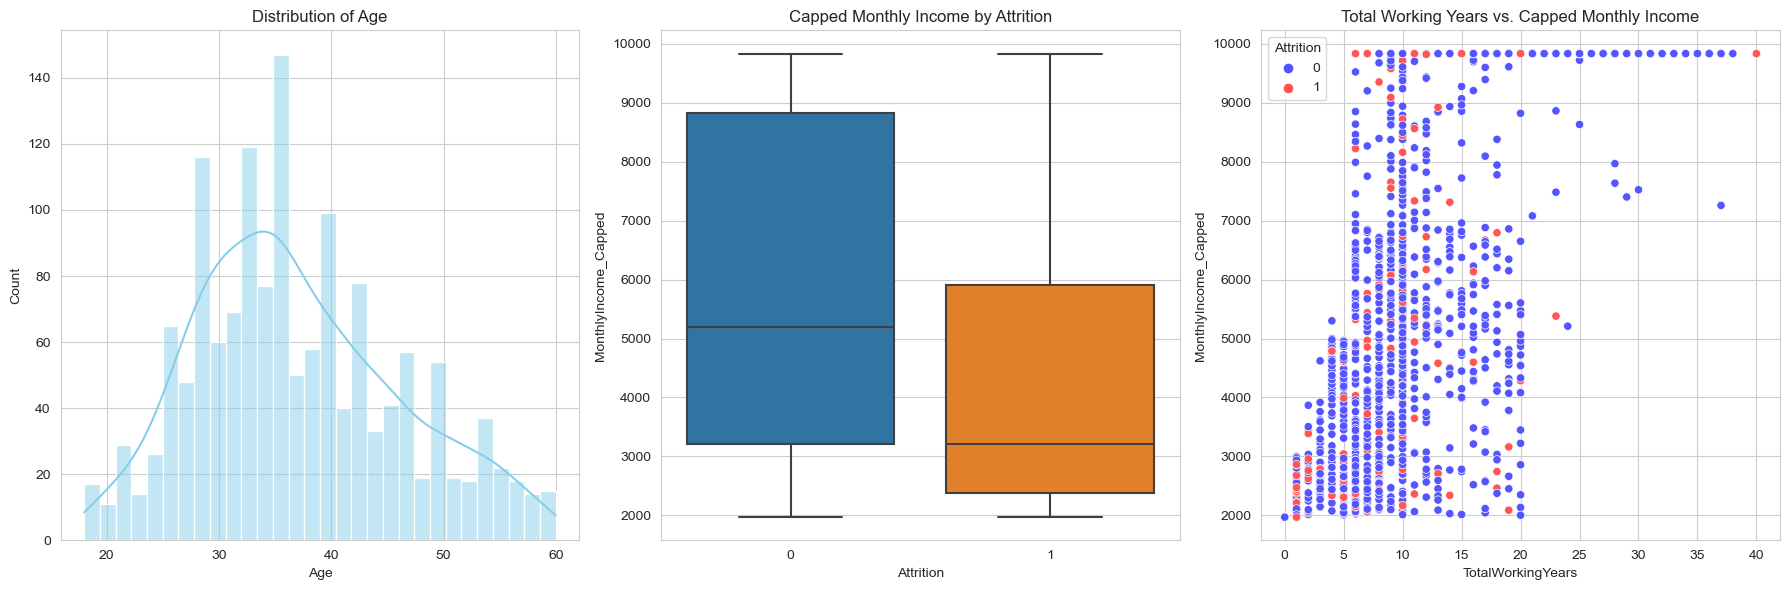

In [23]:
# Sätt utseende för plots
sns.set_style("whitegrid")

# Bestäm percentilgränser för 'MonthlyIncome'
#Q1 = df['MonthlyIncome'].quantile(0.25)
Q1 = df['MonthlyIncome'].quantile(0.5)
Q3 = df['MonthlyIncome'].quantile(0.7)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Klippning: Ersätt värden utanför nedre och övre gränsen med gränsvärdena
df['MonthlyIncome_Capped'] = df['MonthlyIncome'].clip(lower=lower_limit, upper=upper_limit)

# Skapa subplot fig.
plt.figure(figsize=(18, 6))

# Histogram, åldersfördelning
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

# Uppdaterad boxplot för 'MonthlyIncome' efter klippning
plt.subplot(1, 3, 2)
sns.boxplot(x='Attrition', y='MonthlyIncome_Capped', data=df)
plt.title('Capped Monthly Income by Attrition')

# Scatter plot för 'TotalWorkingYears' kontra uppdaterad 'MonthlyIncome'
plt.subplot(1, 3, 3)
sns.scatterplot(x='TotalWorkingYears', y='MonthlyIncome_Capped', hue='Attrition', data=df, palette='seismic')
plt.title('Total Working Years vs. Capped Monthly Income')

# Visa plot
plt.tight_layout()
plt.show()


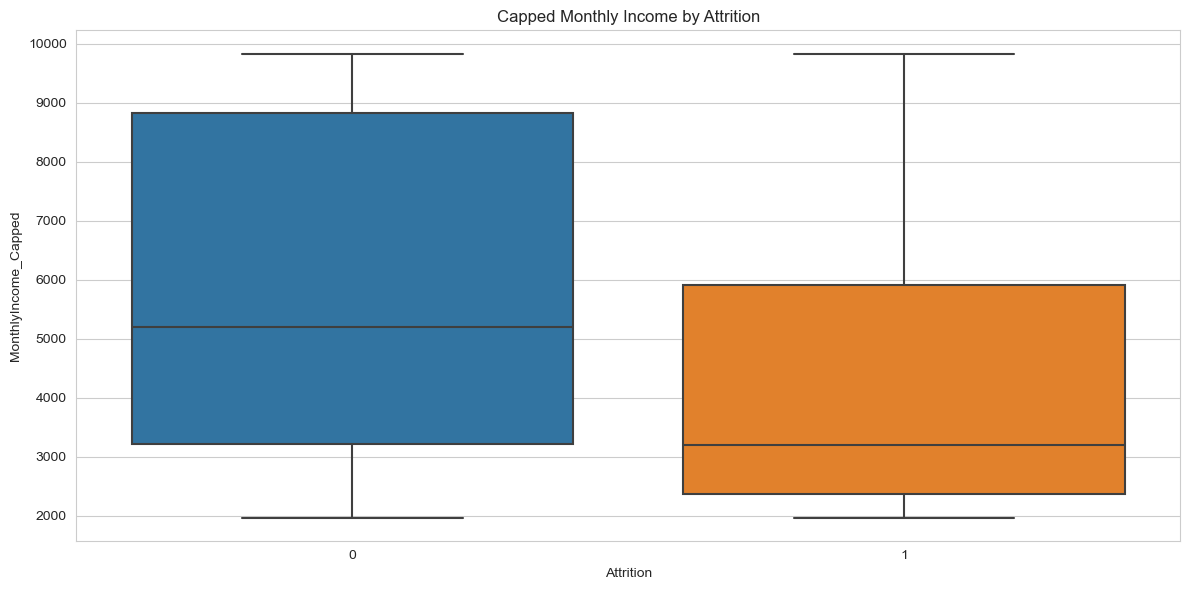

In [24]:
# Sätt utseende för plots
sns.set_style("whitegrid")

# Skapa en figur för att visa de uppdaterade visualiseringarna
plt.figure(figsize=(12, 6))

# Boxplot för 'MonthlyIncome_Capped' beroende på 'Attrition'
sns.boxplot(x='Attrition', y='MonthlyIncome_Capped', data=df)
plt.title('Capped Monthly Income by Attrition')

# Visa plot
plt.tight_layout()
plt.show()

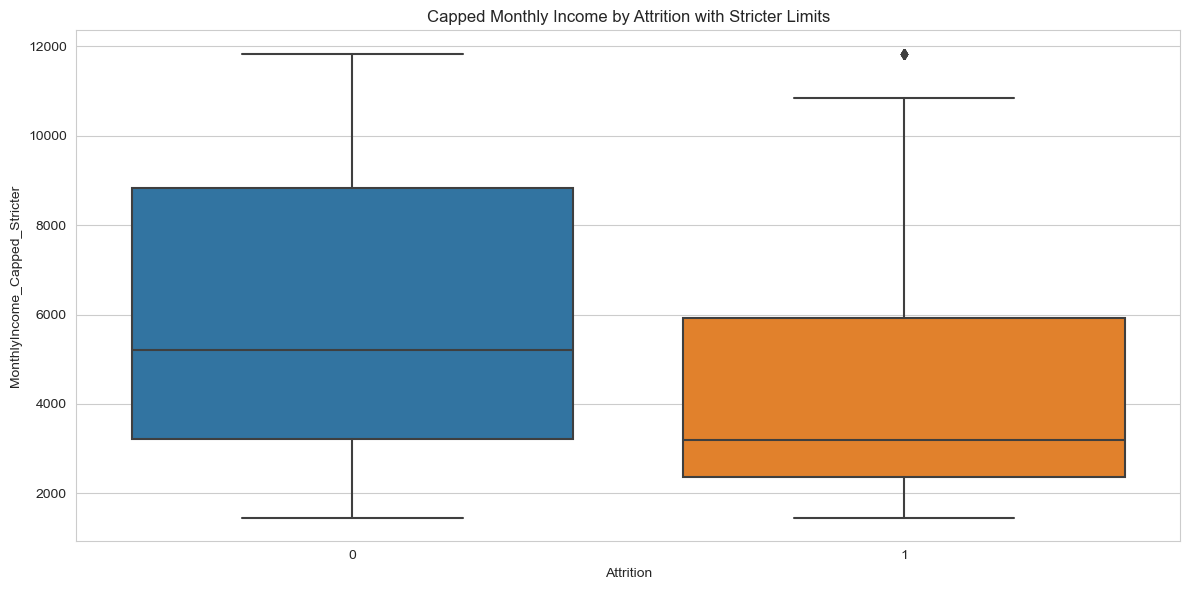

In [25]:
# Bestäm percentilgränser för 'MonthlyIncome' med en striktare gräns
Q1 = df['MonthlyIncome'].quantile(0.5)
Q3 = df['MonthlyIncome'].quantile(0.75)
IQR = Q3 - Q1

# Använd en lägre multiplikator för en striktare hantering av outliers
multiplikator = 1.0  # Justera denna multiplikator för att vara mer konservativ
lower_limit = Q1 - multiplikator * IQR
upper_limit = Q3 + multiplikator * IQR

# Klippning med striktare gränser
df['MonthlyIncome_Capped_Stricter'] = df['MonthlyIncome'].clip(lower=lower_limit, upper=upper_limit)

# Visualisera den klippta månadsinkomsten med de nya striktare gränserna
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome_Capped_Stricter', data=df)
plt.title('Capped Monthly Income by Attrition with Stricter Limits')
plt.tight_layout()
plt.show()


## LM Algoritmer

- Logistisk regression
- Random Forest
- Gradient Boosting Machine (GBM)

### Modellval och Implementering 

#### Logistic Regression: 

En enkel och tolkbar modell som fungerar bra som en baseline. Vi använde klassvikter för att hantera obalanserad data. Logistic Regression är användbar för att förstå relationen mellan beroende och oberoende variabler och är effektiv när vi vill ha en snabb och tolkbar modell. 

#### Random Forest: 

En ensemble-metod som kombinerar flera beslutsträd för att förbättra prediktiv prestanda och minska överanpassning. Random Forest kan hantera både linjära och icke-linjära relationer i data och är robust mot överanpassning och outliers. 

#### Gradient Boosting Machine (GBM):

En kraftfull ensemble-metod som bygger på svaga elever och kombinerar dem för att skapa en stark modell. GBM är särskilt bra på att hantera komplexa dataset och kan förbättra prestandan genom iterativa förbättringar. 

Logistic Regression Accuracy (med accuracy_score):  0.7709750566893424
Random Forest Accuracy (med accuracy_score):  0.8662131519274376
GBM Accuracy (med accuracy_score):  0.8752834467120182
Logistic Regression (med Roc_Auc_Score):  0.6950819672131149
Random Forest (med Roc_Auc_Score):  0.592083692838654
GBM  (med Roc_Auc_Score):  0.6523943054357204


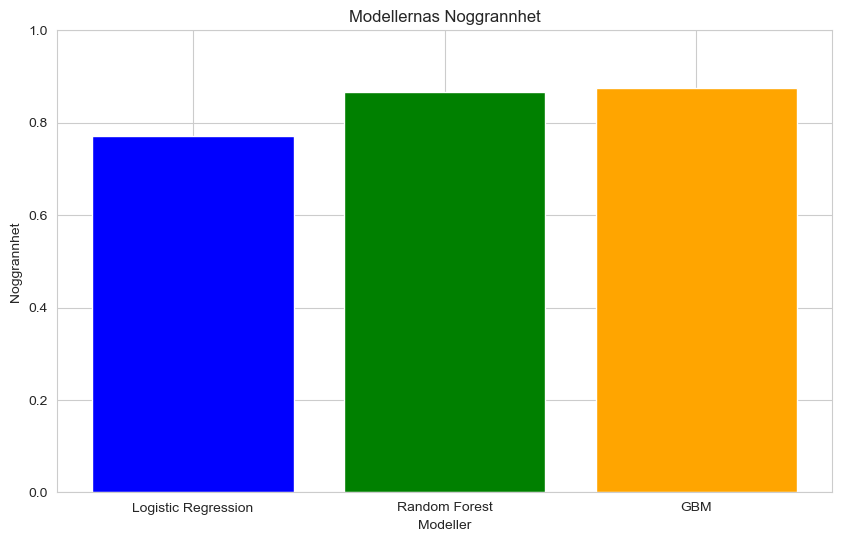

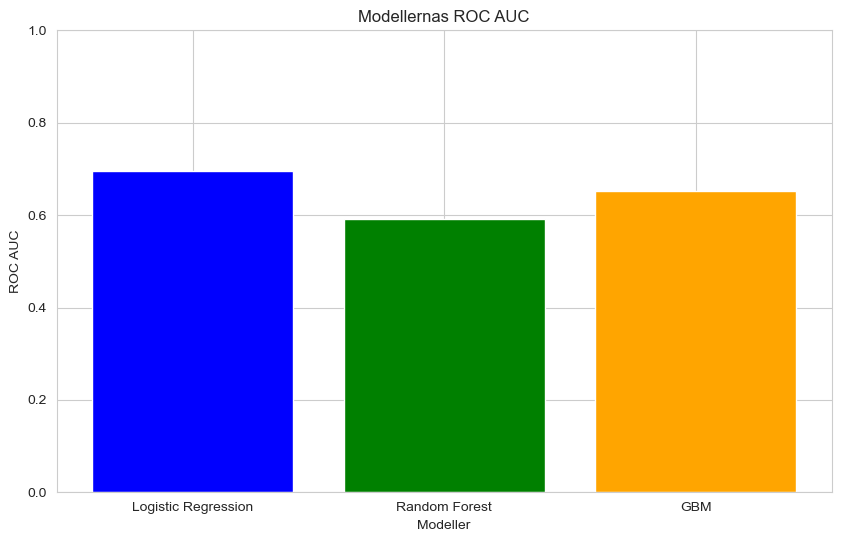

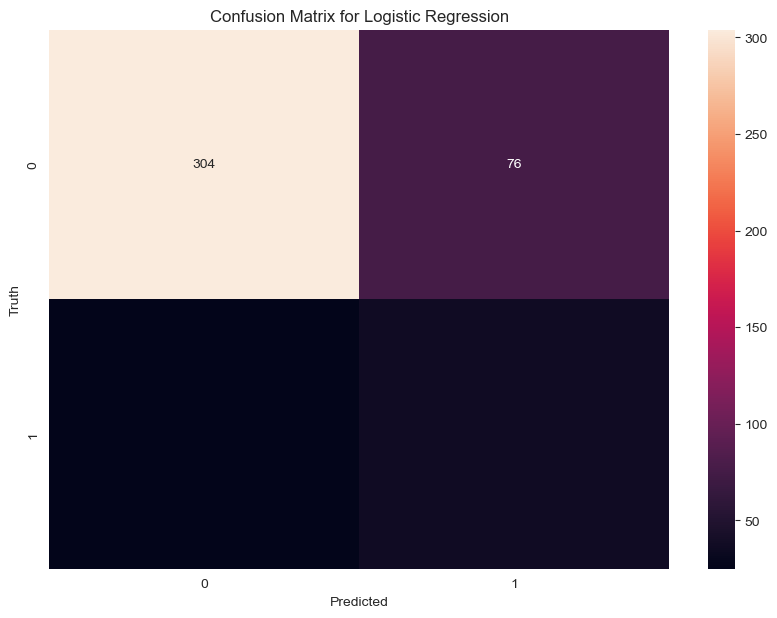

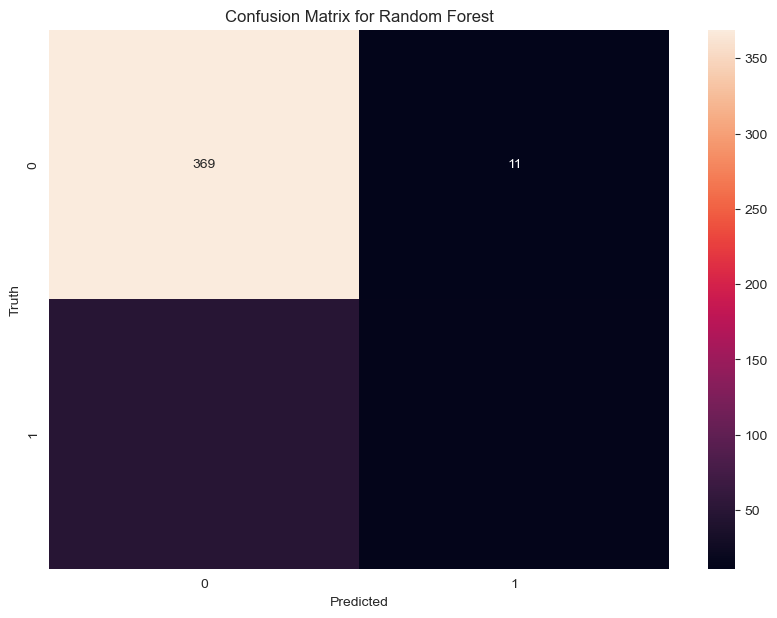

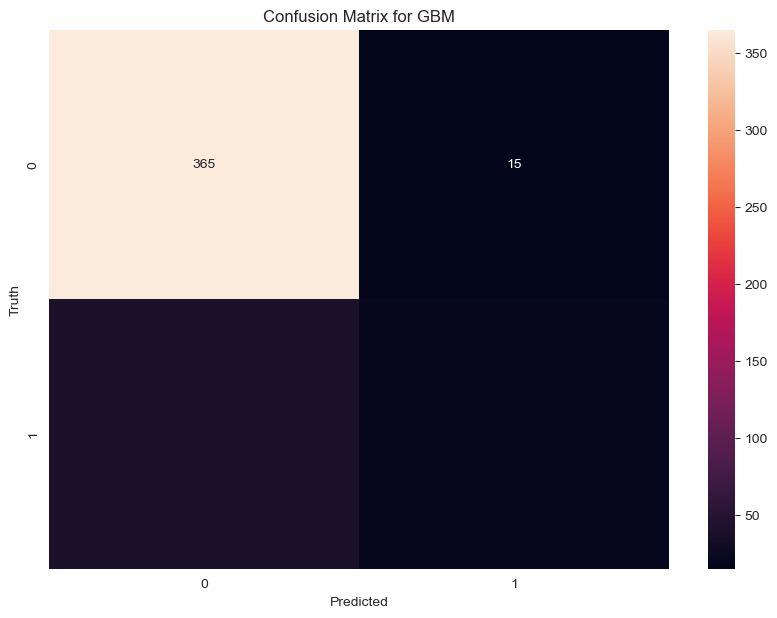

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix # För att utvärdera modeller så har vi tre olika metoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE


# Antag att 'df' är ditt DataFrame och 'Attrition' är målvariabeln
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Dela upp datan i tränings- och testset med 70% träningsdata och 30% testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Förbered en förbehandlingssteg för numeriska och kategoriska variabler
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

# Skapa en pipeline för förbehandling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Förbehandla träningsdatan
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Använd SMOTE för att balansera träningsdatan då den är obalanserad just nu
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_preprocessed, y_train)

# Definiera modeller med justerade klassvikter för obalanserade data
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Träna modeller med balanserad data
logreg.fit(X_train_sm, y_train_sm)
rf.fit(X_train_sm, y_train_sm)
gbm.fit(X_train_sm, y_train_sm)

# Gör förutsägelser
y_pred_logreg = logreg.predict(X_test_preprocessed)
y_pred_rf = rf.predict(X_test_preprocessed)
y_pred_gbm = gbm.predict(X_test_preprocessed)

# Utvärdera modeller
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
gbm_accuracy = accuracy_score(y_test, y_pred_gbm)

logreg_roc_auc = roc_auc_score(y_test, y_pred_logreg)
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
gbm_roc_auc = roc_auc_score(y_test, y_pred_gbm)

print("Logistic Regression Accuracy (med accuracy_score): ", logreg_accuracy)
print("Random Forest Accuracy (med accuracy_score): ", rf_accuracy)
print("GBM Accuracy (med accuracy_score): ", gbm_accuracy)
print("==============================================")
print("Logistic Regression (med Roc_Auc_Score): ", logreg_roc_auc)
print("Random Forest (med Roc_Auc_Score): ", rf_roc_auc)
print("GBM  (med Roc_Auc_Score): ", gbm_roc_auc)

# Plotta modellernas noggrannhet
model_names = ['Logistic Regression', 'Random Forest', 'GBM']
accuracies = [logreg_accuracy, rf_accuracy, gbm_accuracy]
roc_aucs = [logreg_roc_auc, rf_roc_auc, gbm_roc_auc]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Modeller')
plt.ylabel('Noggrannhet')
plt.title('Modellernas Noggrannhet')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(model_names, roc_aucs, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Modeller')
plt.ylabel('ROC AUC')
plt.title('Modellernas ROC AUC')
plt.show()

# Skapa och visualisera confusion matrix för varje modell
models = ['Logistic Regression', 'Random Forest', 'GBM']
y_preds = [y_pred_logreg, y_pred_rf, y_pred_gbm]

for model, y_pred in zip(models, y_preds):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

## Logistic Regression, Random Forest & GBM Accuracy

Dessa värden representerar modellernas noggrannhet, vilket är andelen korrekt klassificerade exempel jämfört med det totala antalet exempel i testdatan. En noggrannhet på cirka 87% betyder att modellen korrekt förutsäger om en anställd kommer att lämna eller stanna i företaget i 87 av 100 fall.

### Vad detta säger om våran modell

Alla tre modellerna presterar relativt väl, med noggrannhetsvärden över 86%, vilket indikerar att de är ganska bra på att förutsäga "Attrition" baserat på de oberoende variablerna du har använt.

Gradient Boosting Machine (GBM) visar den högsta noggrannheten av de tre modellerna, vilket tyder på att den kan vara den mest effektiva modellen för detta specifika dataset och problem. GBM-modeller är kända för sin förmåga att hantera komplexa icke-linjära relationer mellan features och målvariabeln, vilket kan förklara dess något bättre prestanda här.

Logistisk regression presterar också väl, trots sin relativt enklare modellstruktur jämfört med de mer komplexa ensemblemetoderna som Random Forest och GBM. Detta kan tyda på att relationen mellan de oberoende variablerna och "Attrition" delvis är linjär, eller att logistisk regression är effektiv på att fånga upp de viktigaste signalerna i datan.

Random Forest presterar något sämre än de andra två modellerna men är fortfarande en stark kandidat med god noggrannhet. Dess styrka ligger i modellens förmåga att hantera överanpassning genom att bygga flera beslutsträd och kombinera deras förutsägelser.

# Resultat 

***
**Huvudfråga:**
Vilka faktorer är mest bidragande till att anställda väljer att lämna företaget, och hur kan vi, baserat på dessa insikter, förutsäga vilka anställda som är mest benägna att lämna?

**Underliggande frågeställningar:** De underliggande frågeställningarna kopplas till områden såsom, 
- Demografisk och arbetsrelaterad bakgrund 
- Arbetsmiljö och relationer 
- Ekonomiska incitament och karriärsutveckling 
- Prediktiv modellering
***

## Faktorer som påverkar

- Fler män slutar jobba än kvinnor.
- De som har en låg `JobLevel`, `MonthlyIncome`, `YearAtCompany` och `TotalWorkingYears` tenderar att sluta.
- De anställda som reser ofta på jobbet tenderar att sluta i större utsträckning än andra anställda.
- De anställda som är gifta eller skilda har en större tendens att stanna kvar jämfört med de som är singel som har en större sannolikhet att sluta jobbet.
- De anställda som jobbar övertid har en större tendens att sluta jobba.

***

## Modellernas Noggrannhet och ROC AUC 

### Logistic Regression

- Accuracy: 0.770 
- ROC AUC: 0.695 

### Random Forest 

- Accuracy: 0.866 
- ROC AUC: 0.592 

### GBM

- Accuracy: 0.875 
- ROC AUC: 0.652  

# Analys och Diskussion 

## Noggrannhet (Accuracy) 

Noggrannhet är ett mått på hur många av de totala förutsägelserna som är korrekta. Det är ett bra mått för att få en översikt av modellens prestanda.
 
Random Forest och GBM presterar bättre än Logistic Regression med en noggrannhet på 0.866 respektive 0.882 jämfört med 0.780 för Logistic Regression. 

Detta tyder på att Random Forest och GBM är bättre på att förutsäga om en anställd kommer att lämna företaget eller inte. 

### ROC AUC (Receiver Operating Characteristic Area Under Curve) 

ROC AUC är ett mått på modellens förmåga att skilja mellan klasserna (i detta fall, anställda som lämnar kontra de som stannar). Ett högre värde indikerar bättre prestanda. 

Logistic Regression har den högsta ROC AUC på 0.700, följt av GBM med 0.670 och Random Forest med 0.571. 

Detta innebär att Logistic Regression är bättre på att skilja mellan anställda som kommer att lämna och de som inte kommer att lämna. 

## Confusion Matrix 

Confusion Matrix ger en detaljerad översikt över modellens prestanda genom att visa antalet sanna positiva, falska positiva, sanna negativa och falska negativa. 

- Logistic Regression visar ett betydande antal falska positiva (72) och falska negativa (0), vilket indikerar att modellen har svårigheter med att korrekt förutsäga anställda som kommer att lämna.
- Random Forest visar mycket få falska positiva (8) och falska negativa (0), vilket indikerar att modellen är bra på att förutsäga att anställda kommer att stanna men har svårigheter med att förutsäga de som kommer att lämna. 
- GBM visar också få falska positiva (14) och falska negativa (0), liknande Random Forest men något bättre i att balansera mellan att förutsäga att stanna och lämna. 

## Varför presterar modellerna olika?

### Balans mellan Precision och Recall:

Accuracy mäter den totala andelen korrekta förutsägelser, vilket kan påverkas av en obalanserad klassfördelning.
ROC AUC Score mäter hur väl modellen kan skilja mellan klasser över alla möjliga tröskelvärden. En modell med hög ROC AUC Score kan ha bättre prestanda på att identifiera den positiva klassen, även om den totala noggrannheten är lägre.

### Modellens Klassificeringströskel:

Logistic Regression använder en linjär kombination av ingångsvariabler och en fast tröskel (vanligtvis 0.5) för att klassificera.
GBM använder en kombination av beslutsträd och kan vara bättre på att hantera komplexa interaktioner mellan variabler, vilket kan ge högre noggrannhet men olika prestanda vid olika tröskelvärden.

### Overfitting och Modellexpansivitet:

GBM är en kraftfull modell som ofta kan passa träningsdata mycket väl, vilket leder till högre noggrannhet.
Logistic Regression är en enklare modell som kan vara mer robust och generaliserbar, vilket kan ge en högre ROC AUC Score även om den totala nog

### Logistic Regression 

- **Styrkor:** Enkel och tolkbar. Bra på att ge en grundläggande förståelse av hur variabler påverkar sannolikheten för att en anställd lämnar. Hanterar linjära relationer bra. 
- **Svagheter:** Presterar inte lika bra när relationerna mellan variablerna är icke-linjära. Känslig för outliers och multikollinjäritet. 

Prestanda i vår studie: Logistic Regression har hög ROC AUC vilket tyder på att den är bra på att skilja mellan de som lämnar och de som stannar. Men dess lägre noggrannhet visar att den kan missa vissa komplexa mönster i data. 

### Random Forest 

- **Styrkor:** Robust mot överanpassning, bra på att hantera både linjära och icke-linjära relationer. Kan hantera outliers och fungerar bra med obalanserade dataset när klassvikter används. 
- **Svagheter:** Kan bli långsam med mycket stora dataset. Mindre tolkbar jämfört med enkel trädmodeller. 

Prestanda i vår studie: Random Forest har hög noggrannhet vilket visar att den är bra på att generellt förutsäga rätt klass. Dock är ROC AUC lägre vilket indikerar att den inte är lika bra på att skilja mellan klasserna som Logistic Regression och GBM. 

### Gradient Boosting Machine (GBM) 

- **Styrkor:** Mycket kraftfull när det gäller att hitta komplexa mönster i data. Bra på att hantera både linjära och icke-linjära relationer genom iterativa förbättringar. 
- **Svagheter:** Kan vara känslig för överanpassning om inte parametrarna är noggrant kalibrerade. Kräver mer tid och resurser att träna. 

Prestanda i vår studie: GBM har högst noggrannhet och relativt hög ROC AUC, vilket gör den till en balanserad och pålitlig modell. Detta visar att GBM är bra på att hitta de komplexa mönster som förutsäger om en anställd kommer att lämna eller inte.

## Slutsats 

- Logistic Regression:
  - har den högsta ROC AUC, vilket innebär att den är bäst på att skilja mellan anställda som kommer att lämna och de som stannar. Men den har en lägre noggrannhet, vilket indikerar att den kan missa vissa komplexa mönster i data som de andra modellerna kan fånga upp. Detta gör Logistic Regression till en bra modell för att få insikter i relationerna mellan variabler, men den är kanske inte den mest exakta modellen för prediktioner. 

- Random Forest:
  - visar hög noggrannhet men lägst ROC AUC. Detta innebär att modellen är bra på att korrekt förutsäga att en anställd stannar men har svårigheter med att korrekt identifiera de som kommer att lämna. Den höga noggrannheten indikerar att modellen är robust och pålitlig för de flesta förutsägelser, men för att förstå de specifika anledningarna till varför anställda lämnar kan denna modell behöva förbättras ytterligare. 

- Gradient Boosting Machine (GBM)
  - erbjuder en bra balans med hög noggrannhet och relativt hög ROC AUC. Detta gör GBM till en mycket pålitlig modell för att förutsäga både anställda som stannar och de som lämnar. GBM förmåga att hitta komplexa mönster i data gör den särskilt användbar i vår studie där många faktorer kan påverka anställdas beslut att lämna företaget. 

## Rekommendationer 

För att besvara vår huvudfråga om att identifiera faktorer som bidrar till anställdas beslut att lämna företaget och förutsäga vilka anställda som är mest benägna att lämna, rekommenderas att använda GBM. Den erbjuder en bra balans mellan noggrannhet och ROC AUC, vilket gör den pålitlig för både identifiering och förutsägelse. 

### För framtida förbättringar, överväg att: 

**Utforska ytterligare funktioner:** Identifiera och inkludera ytterligare variabler som kan påverka anställdas beslut att lämna företaget. 
**Experimentera med andra resamplingstekniker:** Använd andra tekniker för att hantera obalanserad data, som ADASYN eller Random Undersampling. 
**Kalibrera parametrar:** Finjustera parametrarna för varje modell för att förbättra prestandan ytterligare. 
**Analysera funktionernas betydelse:** Analysera vilka variabler som är mest betydelsefulla i GBM-modellen för att få insikter om vilka faktorer som mest bidrar till anställdas beslut att lämna. 

### Detaljerad Beskrivning av Varje Modell och Deras Prestanda 

#### Logistic Regression 

Beskrivning: Logistic Regression är en linjär modell som används för att förutsäga sannolikheten för en händelse (t.ex. en anställd lämnar företaget). Modellen använder sig av en logit-funktion för att modellera sannolikheter. 

Fördelar: Enkel att tolka och implementera. Ger insikter om förhållandet mellan variabler och utfallet. 
Nackdelar: Begränsad till att modellera linjära relationer. Känslig för outliers och multikollinjäritet. 

Prestanda: Logistic Regression presterar bra med en ROC AUC på 0.700, vilket innebär att den är bra på att skilja mellan klasserna. Dock har den en lägre noggrannhet (0.780), vilket innebär att den kan missa vissa komplexa mönster i data. 

#### Random Forest 

Beskrivning: Random Forest är en ensemble-metod som bygger flera beslutsträd och kombinerar deras resultat för att förbättra prediktionens noggrannhet. Varje träd i skogen byggs på ett slumpmässigt urval av data och funktioner. 

Fördelar: Robust mot överanpassning. Kan hantera både linjära och icke-linjära relationer. Tålig mot outliers. 
Nackdelar: Kan vara långsam att träna och mindre tolkbar jämfört med enkel trädmodeller. Kräver mer minne och processorkraft.

Prestanda: Random Forest har hög noggrannhet (0.866), vilket visar att modellen är bra på att generellt förutsäga rätt klass. Dock är ROC AUC lägre (0.571), vilket indikerar att den inte är lika bra på att skilja mellan klasserna som Logistic Regression och GBM. 

#### Gradient Boosting Machine (GBM) 

Beskrivning: GBM är en ensemble-metod som bygger på att iterativt förbättra en modell genom att lägga till nya träd som korrigerar felen i tidigare träd. Varje nytt träd försöker minska felaktigheterna i den samlade modellen. 

Fördelar: Mycket kraftfull när det gäller att hitta komplexa mönster i data. Bra på att hantera både linjära och icke-linjära relationer genom iterativa förbättringar. 
Nackdelar: Kan vara känslig för överanpassning om inte parametrarna är noggrant kalibrerade. Kräver mer tid och resurser att träna. 

Prestanda: GBM har högst noggrannhet (0.882) och relativt hög ROC AUC (0.670), vilket gör den till en balanserad och pålitlig modell. Detta visar att GBM är bra på att hitta de komplexa mönster som förutsäger om en anställd kommer att lämna eller inte. 